In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import packages

In [ ]:
pip install ta

In [ ]:
pip install arch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
import os
import math

import ta

# using the style for the plot
plt.style.use('classic')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

%config inlinebackend.figure_format = 'svg'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Prepare functions

## Interval data and chart

In [ ]:
def prepare_df(df, timeframe, use_log_change = False):

    assert timeframe in ['1min', '5min', '15min', '1H', '1D']

    if timeframe != '1min':
        df = df.resample(rule = timeframe).agg(
            {'OPEN': 'first',
            'HIGH': 'max',
            'LOW': 'min',
            'CLOSE': 'last',
            'VOLUME': 'sum',
            }).dropna()

    df['AVG_PRICE'] = (df['OPEN'] + df['HIGH'] + df['LOW'] + df['CLOSE'])/4

    df['FLAG_INCREASE_CANDLE'] = np.where(df['CLOSE'] >= df['OPEN'], 1, -1)

    df['BODY'] = df.apply(lambda x: max(x['OPEN'], x['CLOSE']) - min(x['OPEN'], x['CLOSE']) + 0.01,
                                    axis = 1)
    df['UPPER_SHADOW'] = df.apply(lambda x: x['HIGH'] - max(x['OPEN'], x['CLOSE']) + 0.01,
                                            axis = 1)
    df['LOWER_SHADOW'] = df.apply(lambda x: min(x['OPEN'], x['CLOSE']) - x['LOW'] + 0.01,
                                            axis = 1)

    df['FLAG_LONG_UPPER_SHADOW'] = np.where(df['UPPER_SHADOW'] >= df['BODY'], 1, -1)
    df['FLAG_LONG_LOWER_SHADOW'] = np.where(df['LOWER_SHADOW'] >= df['BODY'], 1, -1)

    df['FLAG_HIGHER_HIGH(20)'] = np.where(df['HIGH'] >= df['HIGH'].shift(20), 1, -1)
    df['FLAG_HIGHER_LOW(20)'] = np.where(df['LOW'] >= df['LOW'].shift(20), 1, -1)


    #Moving average of volume
    df['AVG_VOL(50)'] = df['VOLUME'].rolling(50).mean()
    df['FLAG_OVER_AVG_VOL(50)'] = np.where(df['VOLUME'] >= df['AVG_VOL(50)'], 1, -1)

    df['AVG_VOL(200)'] = df['VOLUME'].rolling(200).mean()
    df['FLAG_OVER_AVG_VOL(200)'] = np.where(df['VOLUME'] >= df['AVG_VOL(200)'], 1, -1)

    df['FLAG_UPTREND_VOL(20)'] = np.where(df['VOLUME'] >= df['VOLUME'].shift(20), 1, -1)


    #RSI
    df['RSI'] = ta.momentum.RSIIndicator(df['CLOSE'],
                                            window = 14).rsi()

    df['FLAG_UNDER_30_RSI'] = np.where(df['RSI'] < 30, 1, -1)
    df['FLAG_OVER_70_RSI'] = np.where(df['RSI'] > 70, 1, -1)
    df['FLAG_UPTREND_RSI(20)'] = np.where(df['RSI'] >= df['RSI'].shift(20), 1, -1)

    #Exponential moving average
    df['EMA(50)'] = ta.trend.EMAIndicator(df['CLOSE'],
                                            window = 50).ema_indicator()
    df['POSITION_EMA(50)'] = df.apply(lambda x: 1 if x['EMA(50)'] >= x['HIGH']
                                                                else (2 if x['EMA(50)'] >= max(x['OPEN'], x['CLOSE'])
                                                                else (3 if x['EMA(50)'] >= min(x['OPEN'], x['CLOSE'])
                                                                else (4 if x['EMA(50)'] >= x['LOW'] else 5)
                                                                    )),
                                                axis = 1)


    df['EMA(200)'] = ta.trend.EMAIndicator(df['CLOSE'],
                                            window = 200).ema_indicator()
    df['POSITION_EMA(200)'] = df.apply(lambda x: 1 if x['EMA(200)'] >= x['HIGH']
                                                                else (2 if x['EMA(200)'] >= max(x['OPEN'], x['CLOSE'])
                                                                else (3 if x['EMA(200)'] >= min(x['OPEN'], x['CLOSE'])
                                                                else (4 if x['EMA(200)'] >= x['LOW'] else 5)
                                                                    )),
                                                axis = 1)


    if use_log_change == True:
        log_cols = [col for col in df.columns if ((col[:4] != 'FLAG')
                                                & (col[:8] != 'POSITION')
                                                & (col != 'RSI')
                                                  )
        ]

        for col in log_cols:
            df['LOG_CHANGE_' + col] = np.log(df[col]/df[col].shift(1))*100

    #returns
    # df['Ret(t)'] = 100*(df['CLOSE'] - df['CLOSE'].shift(1))/df['CLOSE'].shift(1)

    return(df)

In [ ]:
def plot(df_plot, timeframe):
    assert timeframe in ['1min', '5min', '15min', '1H', '1D']
    # Assuming df_plot is your DataFrame with columns: 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'EMA50', 'EMA200', 'RSI'

    # Define subplot heights and widths
    subplot_heights = [600, 100, 100]  # Adjust these values based on your preferences
    subplot_widths = [1]  # Only one column

    # Create subplot with 3 rows and 1 column
    fig = make_subplots(rows=3,
                        cols=1,
                        shared_xaxes=True,
                        subplot_titles=('Candlestick with EMA Lines', 'Volume Chart', 'RSI Chart'),
                        row_heights=subplot_heights,
                        column_widths=subplot_widths,
                        vertical_spacing = 0.05,  # Set the spacing between rows
                        )

    # Subplot 1: Candlestick chart with EMA lines
    cd = go.Candlestick(x=df_plot.index,
                        open=df_plot['OPEN'],
                        high=df_plot['HIGH'],
                        low=df_plot['LOW'],
                        close=df_plot['CLOSE'],
                        increasing=dict(line=dict(color='green', width = 2)),  # Adjust the line attributes for increasing candles
                        decreasing=dict(line=dict(color='red', width = 2)),
                        name='Candlesticks')

    ema50 = go.Scatter(x=df_plot.index,
                             y=df_plot['EMA(50)'],
                             mode='lines',
                             name='EMA50',
                             line=dict(color='blue', width = 2))

    ema200 = go.Scatter(x=df_plot.index,
                             y=df_plot['EMA(200)'],
                             mode='lines',
                             name='EMA200',
                             line=dict(color='orange', width = 2))


    fig.add_trace(cd, row=1, col=1)
    fig.add_trace(ema50,
                  row=1,
                  col=1)
    fig.add_trace(ema200,
                  row=1,
                  col=1)

    # Subplot 2: Volume bar chart
    vol = go.Bar(x=df_plot.index,
                         y=df_plot['VOLUME'],
                         name='Volume',
                         marker=dict(color='blue'),
                         #width = 0
                         )

    av50 = go.Scatter(x=df_plot.index,
                             y=df_plot['AVG_VOL(50)'],
                             mode='lines',
                             name='AVG_VOL50',
                             line=dict(color='red', width = 2))

    av200 = go.Scatter(x=df_plot.index,
                             y=df_plot['AVG_VOL(200)'],
                             mode='lines',
                             name='AVG_VOL200',
                             line=dict(color='orange', width = 2))


    fig.add_trace(vol,
                  row=2,
                  col=1)
    fig.add_trace(av50,
                  row=2,
                  col=1)
    fig.add_trace(av200,
                  row=2,
                  col=1)

    # Subplot 3: RSI chart with threshold lines

    rsi = go.Scatter(x=df_plot.index,
                             y=df_plot['RSI'],
                             mode='lines',
                             name='RSI',
                             line=dict(color='mediumpurple', width = 2))

    rsi30 = dict(type='line',
                       x0=df_plot.index.min(),
                       x1=df_plot.index.max(),
                       y0=30,
                       y1=30,
                       line=dict(color='white', width=1, dash='dash'))

    rsi70 = dict(type='line',
                       x0=df_plot.index.min(),
                       x1=df_plot.index.max(),
                       y0=70,
                       y1=70,
                       line=dict(color='white', width=1, dash='dash'))

    fig.add_trace(rsi,
                  row=3,
                  col=1)

    fig.add_shape(rsi30,
                  row=3,
                  col=1)

    fig.add_shape(rsi70, row=3, col=1)


    # Add darker shaded area between 30 and 70 in the RSI plot
    fig.add_shape(
        type='rect',
        x0=df_plot.index.min(),
        x1=df_plot.index.max(),
        y0=30,
        y1=70,
        fillcolor='rgba(200, 160, 255, 0.2)',  # Light purple color with opacity
        line=dict(color='rgba(255, 255, 255, 0)'),  # Set border color and opacity
        row=3,
        col=1
    )

    # Add slider
    fig.update_layout(
        xaxis=dict(
            rangeslider=dict(
                visible=False,
                thickness=0.05,  # Adjust the thickness of the slider
                bgcolor='rgba(0,0,0,0.1)',  # Set the background color of the slider
            ),
            type='date',
            ),

        height = 800,
        width = 1300,
        plot_bgcolor='black',  # Transparent background
        paper_bgcolor='black',  # Transparent paper background
        font = dict(color = 'white'),
        legend = dict(x = 1.01, y = 1)
    )

    # Fix y-axis range for each subplot
    fig.update_yaxes(autorange = True, range=[df_plot['CLOSE'].min(), df_plot['CLOSE'].max()], row=1, col=1)  # Adjust as needed
    fig.update_yaxes(autorange = True, range=[0, df_plot['VOLUME'].max()], row=2, col=1)  # Adjust as needed
    fig.update_yaxes(autorange = True, range=[0, 100], row=3, col=1)  # Assuming RSI values range from 0 to 100

    if timeframe == '1D':
        rangebreaks = [
            dict(bounds=["sat", "mon"]),  # Exclude weekends
        ]
    else:
        rangebreaks=[
            dict(bounds=["sat", "mon"]),  # Exclude weekends
            dict(bounds=[15, 9], pattern="hour"),  # hide hours outside of 9:00 - 15:00
            dict(bounds=[12, 13], pattern="hour"),  # hide hours outside of 12:00 - 13:00
        ]

    fig.update_xaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='white',
        gridcolor='grey',
        rangebreaks=rangebreaks
    )

    fig.update_yaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='white',
        gridcolor='grey'
    )

    # Write HTML output
    # fig.write_html(f'{path}/plot.html')

    # Show the figure
    fig.show()

## Support, resistance

In [ ]:
def prepare_df_sr(sr_range, patience_range, patience_time, df_observe):

    cnt = 0

    bins = []

    while df_observe['LOW'].min() + cnt*sr_range <= df_observe['HIGH'].max():
        bins.append(df_observe['LOW'].min() + cnt*sr_range)
        cnt += 1

    df_observe['PRICE_RANGE'] = pd.cut(df_observe['AVG_PRICE'], bins = bins)

    price_hist = pd.pivot_table(df_observe.copy(), index = 'PRICE_RANGE', values = 'AVG_PRICE', aggfunc = 'count')
    price_hist.columns = ['NUM_TOUCH']
    price_hist['PRICE_RANKING'] = range(1, len(price_hist) + 1, 1)
    price_hist['CUMULATIVE_TOUCH'] = price_hist['NUM_TOUCH'].cumsum()

    price_hist['PERC_NUM_TOUCH'] = price_hist['NUM_TOUCH']/price_hist['NUM_TOUCH'].sum()*100
    price_hist['PERC_CUM_NUM_TOUCH'] = price_hist['CUMULATIVE_TOUCH']/price_hist['NUM_TOUCH'].sum()*100

    price_hist = price_hist[['PRICE_RANKING', 'NUM_TOUCH', 'CUMULATIVE_TOUCH', 'PERC_NUM_TOUCH', 'PERC_CUM_NUM_TOUCH']]


    #=================== ADJUST POINTS 1 ===================#
    '''
    Percentile rank based on the number of times prices touch the range;
    +0.5 or -0.5 based on patience_range, i.e. +0.5 to ranks that is maximum within patience_range and -1 otherwise
    --> eliminate the chances that 2 consecutive ranges being support and/or resistance.
    '''
    price_hist['RANK_NUM_TOUCH'] = price_hist['PERC_NUM_TOUCH'].rank(method = 'first', pct = True)

    # Create a forward rolling view
    price_hist['ROLL_RANK_FORWARD'] = price_hist['RANK_NUM_TOUCH'].rolling(window = patience_range).max()

    # Create a backward rolling view by reversing the DataFrame and applying forward rolling
    price_hist['ROLL_RANK_BACKWARD'] = price_hist[::-1]['RANK_NUM_TOUCH'].rolling(window = patience_range).max()
    price_hist['ADJUST_POINTS_1'] = np.where((price_hist['ROLL_RANK_FORWARD'] == price_hist['ROLL_RANK_BACKWARD']) &
                                       (price_hist['RANK_NUM_TOUCH'] > 0) &
                                       (price_hist['ROLL_RANK_FORWARD'] == price_hist['RANK_NUM_TOUCH']),
                                    0.5, -1)

    #=================== ADJUST POINTS 2 ===================#
    '''
    Points based on the number of times prices REVERT or BREAK OUT of the range;
    At each time step, flag -1 if price is less than the range, 0 if it is within the range and 1 otherwise;
    FORWARD_TREND will be sum of the flag over the forward patience_time, and similarly for PREV_TREND;
    The product between FORWARDTREND and PREV_TREND >= 0 at the time price within the range --> Add 1 points to the range; otherwise -2.
    '''
    ranges = price_hist.copy().index

    for r in ranges:
        df_observe[r] = df_observe['AVG_PRICE'].apply(lambda x: -1 if x <= r.left
                                                else (0 if x in r
                                                        else 1
                                                        ))
        # Create a forward rolling view
        df_observe[f'{r}_FORWARD_TREND'] = df_observe[r].rolling(window = patience_time).sum()

        # Create a backward rolling view by reversing the DataFrame and applying forward rolling
        df_observe[f'{r}_PREV_TREND'] = df_observe[::-1][r].rolling(window = patience_time).sum()

        # Adjust points 2 based on revert and break out
        df_observe[f'{r}_REVERT_POINTS'] = np.where((df_observe[r] == 0) & (df_observe[f'{r}_FORWARD_TREND']*df_observe[f'{r}_FORWARD_TREND'] >= 0),
                                            1,
                                            -2)

    adjust2 = pd.DataFrame(df_observe.filter(like = 'REVERT_POINTS').sum().rank(pct = True, method = 'first'))

    adjust2.index = ranges

    adjust2.columns = ['ADJUST_POINTS_2']

    price_hist = pd.concat([price_hist, adjust2], axis = 1)

    price_hist['SR_SCORE'] = price_hist['RANK_NUM_TOUCH'] + price_hist['ADJUST_POINTS_1'] + price_hist['ADJUST_POINTS_2']
    price_hist['SR_RANK'] = price_hist['SR_SCORE'].rank(ascending = False)

    price_hist = price_hist.drop(columns = ['ROLL_RANK_FORWARD', 'ROLL_RANK_BACKWARD'])

    return(price_hist)

In [ ]:
def sr_score(param, df_observe):
    price_hist = prepare_df_sr(sr_range = param['sr_range'],
                    patience_range = param['patience_range'],
                    patience_time = param['patience_time'],
                    df_observe = df_observe)

    sum_score = price_hist.loc[(price_hist['SR_RANK'] <= param['max_num_range']) & (price_hist['SR_SCORE'] >= param['cutoff']), 'SR_SCORE'].sum()
    return(sum_score)

In [ ]:
def search_sr(df_observe):
    from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
    from hyperopt.pyll.base import scope

    pr_arr = [3, 4, 5]
    pt_arr = [3, 4, 5]
    max_num_arr = [3, 4, 5]

    space = {
        "sr_range": hp.uniform("sr_range", 3, 5),
        "patience_range": hp.choice("patience_range", [3, 4, 5]),
        "patience_time": hp.choice("patience_time", [3, 4, 5]),
        "max_num_range": hp.choice("max_num_range", [3, 4, 5]),
        "cutoff": hp.uniform("cutoff", 2, 5)
    }


    def hyperparameter_tuning(params):
        score = sr_score(params, df_observe.copy())
        return {"loss": -score, "status": STATUS_OK}

    # Initialize trials object
    trials = Trials()

    best = fmin(
        fn=hyperparameter_tuning,
        space = space,
        algo=tpe.suggest,
        max_evals=200,
        trials=trials
    )

    best['patience_range'] = pr_arr[best['patience_range']]
    best['patience_time'] = pr_arr[best['patience_time']]
    best['max_num_range'] = pr_arr[best['max_num_range']]


    return(best)

In [ ]:
def plot_sr(df_observe, timeframe, sr_range, patience_range, patience_time, max_num_sr, cutoff):
    price_hist = prepare_df_sr(df_observe = df_observe,
                               sr_range = sr_range,
                               patience_range = patience_range,
                               patience_time = patience_time)

    # Assuming df is your DataFrame with columns: 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'EMA50', 'EMA200', 'RSI'

    # Define subplot heights and widths
    subplot_heights = [1]  # Adjust these values based on your preferences
    subplot_widths = [1]  # Only one column

    # Create subplot with 3 rows and 1 column
    fig = make_subplots(rows=1,
                        cols=1,
                        shared_xaxes=True,
                        subplot_titles=('Candlestick with EMA Lines'),
                        row_heights=subplot_heights,
                        column_widths=subplot_widths,
                        vertical_spacing = 0.05,  # Set the spacing between rows
                        )

    # Subplot 1: Candlestick chart with EMA lines
    cd = go.Candlestick(x=df_observe.index,
                    open=df_observe['OPEN'],
                    high=df_observe['HIGH'],
                    low=df_observe['LOW'],
                    close=df_observe['CLOSE'],
                    increasing=dict(line=dict(color='green', width = 2)),  # Adjust the line attributes for increasing candles
                    decreasing=dict(line=dict(color='red', width = 2)),
                    name='Candlesticks')

    fig.add_trace(cd, row=1, col=1)

    for idx, i in enumerate(price_hist.index):
        if price_hist.loc[i, 'SR_RANK'] <= max_num_sr and price_hist.loc[i, 'SR_SCORE'] >= cutoff:
            uprange = dict(type='line',
                                x0=df_observe.index.min(),
                                x1=df_observe.index.max(),
                                y0=price_hist.index[idx].right,
                                y1=price_hist.index[idx].right,
                                line=dict(color='white', width=1, dash='dash'))

            lowrange = dict(type='line',
                            x0=df_observe.index.min(),
                            x1=df_observe.index.max(),
                            y0=price_hist.index[idx].left,
                            y1=price_hist.index[idx].left,
                            line=dict(color='white', width=1, dash='dash'))

            fig.add_shape(uprange,
                        row=1,
                        col=1)

            fig.add_shape(lowrange,
                        row=1,
                        col=1)

            fig.add_shape(
                type='rect',
                x0=df_observe.index.min(),
                x1=df_observe.index.max(),
                y0=price_hist.index[idx].left,
                y1=price_hist.index[idx].right,
                fillcolor='rgba(200, 160, 255, 0.2)',  # Light purple color with opacity
                line=dict(color='rgba(255, 255, 255, 0)'),  # Set border color and opacity
                row=1,
                col=1
            )


    # Add slider
    fig.update_layout(
        xaxis=dict(
            rangeslider=dict(
                visible=False,
                thickness=0.05,  # Adjust the thickness of the slider
                bgcolor='rgba(0,0,0,0.1)',  # Set the background color of the slider
            ),
            type='date',
            ),

        height = 800,
        width = 1300,
        plot_bgcolor='black',  # Transparent background
        paper_bgcolor='black',  # Transparent paper background
        font = dict(color = 'white'),
        legend = dict(x = 1.01, y = 1),
        hovermode="x unified"

    )

    # Fix y-axis range for each subplot
    fig.update_yaxes(autorange = True, range=[df_observe['CLOSE'].min(), df_observe['CLOSE'].max()], row=1, col=1)  # Adjust as needed

    if timeframe == '1D':
        rangebreaks = [
            dict(bounds=["sat", "mon"]),  # Exclude weekends
        ]
    else:
        rangebreaks=[
            dict(bounds=["sat", "mon"]),  # Exclude weekends
            dict(bounds=[15, 9], pattern="hour"),  # hide hours outside of 9:00 - 15:00
            dict(bounds=[12, 13], pattern="hour"),  # hide hours outside of 12:00 - 13:00
        ]

    fig.update_xaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='white',
        gridcolor='grey',
        rangebreaks=rangebreaks
    )

    fig.update_yaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='white',
        gridcolor='grey'
    )

    # sum_score = price_hist.loc[(price_hist['SR_RANK'] <= max_num_sr) & (price_hist['SR_SCORE'] >= cutoff), 'SR_SCORE'].sum()

    # fig.add_annotation(
    # text=sum_score,
    # x=df_observe.index.min(),  # X-coordinate of the text box
    # y=df_observe['HIGH'].max(),  # Y-coordinate of the text box
    # showarrow=True,
    # arrowhead=7,
    # ax=0,
    # ay=-40
    # )

    # Write HTML output
    # fig.write_html(f'{path}/plot.html')

    # Show the figure
    fig.show()

## Extrema

In [ ]:
from scipy.signal import argrelmin
from scipy.signal import argrelmax

In [ ]:
def extrema(df_ex, order = 10):

    local_max_indices = argrelmax(data = df_ex.iloc[order: -order, :]['HIGH'].values, axis = 0, order = order)[0]
    local_min_indices = argrelmin(data = df_ex.iloc[order: -order, :]['LOW'].values, axis = 0, order = order)[0]

    return(local_max_indices, local_min_indices)


def plot_extrema(df_plot, timeframe, order, local_max_indices, local_min_indices):
    # Assuming df is your DataFrame with columns: 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'EMA50', 'EMA200', 'RSI'

    # Define subplot heights and widths
    subplot_heights = [1]  # Adjust these values based on your preferences
    subplot_widths = [1]  # Only one column

    # Create subplot with 3 rows and 1 column
    fig = make_subplots(rows=1,
                        cols=1,
                        shared_xaxes=True,
                        subplot_titles=('Candlestick with EMA Lines'),
                        row_heights=subplot_heights,
                        column_widths=subplot_widths,
                        vertical_spacing = 0.05,  # Set the spacing between rows
                        )

    # Subplot 1: Candlestick chart with EMA lines
    cd = go.Candlestick(x=df_plot.index,
                        open=df_plot['OPEN'],
                        high=df_plot['HIGH'],
                        low=df_plot['LOW'],
                        close=df_plot['CLOSE'],
                        increasing=dict(line=dict(color='green', width = 2)),  # Adjust the line attributes for increasing candles
                        decreasing=dict(line=dict(color='red', width = 2)),
                        name='Candlesticks'
                        )

    fig.add_trace(cd, row=1, col=1)


    # Add slider
    fig.update_layout(
        xaxis=dict(
            rangeslider=dict(
                visible=False,
                thickness=0.05,  # Adjust the thickness of the slider
                bgcolor='rgba(0,0,0,0.1)',  # Set the background color of the slider
            ),
            type='date',
            ),

        height = 800,
        width = 1300,
        plot_bgcolor='black',  # Transparent background
        paper_bgcolor='black',  # Transparent paper background
        font = dict(color = 'white'),
        legend = dict(x = 1.01, y = 1)
    )

    # Fix y-axis range for each subplot
    fig.update_yaxes(autorange = True, range=[df_plot['CLOSE'].min(), df_plot['CLOSE'].max()], row=1, col=1)  # Adjust as needed

    if timeframe == '1D':
        rangebreaks = [
            dict(bounds=["sat", "mon"]),  # Exclude weekends
        ]
    else:
        rangebreaks=[
            dict(bounds=["sat", "mon"]),  # Exclude weekends
            dict(bounds=[15, 9], pattern="hour"),  # hide hours outside of 9:00 - 15:00
            dict(bounds=[12, 13], pattern="hour"),  # hide hours outside of 12:00 - 13:00
        ]

    fig.update_xaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='white',
        gridcolor='grey',
        rangebreaks=rangebreaks
    )

    fig.update_yaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='white',
        gridcolor='grey'
    )

    for id in local_max_indices:
        fig.add_annotation(
            text='Local max',
            x=df_plot.index[id + order],  # X-coordinate of the text box
            y=df_plot.iloc[id + order,:]['HIGH'],  # Y-coordinate of the text box
            showarrow=True,
            arrowhead=1,
            arrowcolor = 'white',
            arrowside = 'end',
            opacity = 0.8,
            ax=0,
            ay=-45
        )

    for id in local_min_indices:
        fig.add_annotation(
            text='Local min',
            x=df_plot.index[id + order],  # X-coordinate of the text box
            y=df_plot.iloc[id + order,:]['LOW'],  # Y-coordinate of the text box
            showarrow=True,
            arrowhead=1,
            arrowcolor = 'white',
            arrowside = 'end',
            opacity = 0.8,
            ax=0,
            ay=45
        )

    # Write HTML output
    # fig.write_html(f'{path}/plot.html')

    # Show the figure
    fig.show()

# Data

In [ ]:
path = '/content/drive/MyDrive/Projects/Intraday trading'

# df = pd.read_csv(f'{path}/data.csv')

# df.to_pickle(f'{path}/data.pkl')

In [ ]:
df = pd.read_pickle(f'{path}/Data/data.pkl')
df = df.set_index('Date/Time')
df.index = pd.to_datetime(df.index)

df.columns = [col.upper() for col in df.columns]

In [ ]:
list_of_dates = sorted(set(df.index.date))

In [ ]:
temp = []

for idx, i in enumerate(list_of_dates):
    if df[df.index.date == i].shape != (243, 5):
        temp.append(df[df.index.date == i].index.values)

In [ ]:
index_to_drop = temp[0]

for id, i in enumerate(temp):
    index_to_drop = np.concatenate((index_to_drop, temp[id]), axis = None)

In [ ]:
index_to_drop

array(['2019-01-31T09:00:00.000000000', '2019-01-31T09:01:00.000000000',
       '2019-01-31T09:02:00.000000000', ...,
       '2020-11-13T14:29:00.000000000', '2020-11-13T14:30:00.000000000',
       '2020-11-13T14:45:00.000000000'], dtype='datetime64[ns]')

In [ ]:
df = df[~df.index.isin(index_to_drop)]

# H_index

## Prepare train, test data

In [ ]:
df_5_min = prepare_df(df,
                      timeframe = '5min',
                      use_log_change = True
                      )

df_5_min = df_5_min.dropna()
df_5_min = df_5_min[df_5_min.index >= datetime.strptime(str(df_5_min.index[0] + timedelta(days = 1))[:10], '%Y-%m-%d')
]


In [ ]:
list_of_dates = sorted(set(df_5_min.index.date))

In [ ]:
features = ['FLAG_INCREASE_CANDLE',
            'BODY',
            'UPPER_SHADOW',
            'LOWER_SHADOW',
            'FLAG_LONG_UPPER_SHADOW',
            'FLAG_LONG_LOWER_SHADOW',
            'FLAG_HIGHER_HIGH(20)',
            'FLAG_HIGHER_LOW(20)',
            'FLAG_OVER_AVG_VOL(50)',
            'FLAG_OVER_AVG_VOL(200)',
            'FLAG_UPTREND_VOL(20)',
            'RSI',
            'FLAG_UNDER_30_RSI',
            'FLAG_OVER_70_RSI',
            'FLAG_UPTREND_RSI(20)',
            'POSITION_EMA(50)',
            'POSITION_EMA(200)',
            'LOG_CHANGE_OPEN',
            'LOG_CHANGE_HIGH',
            'LOG_CHANGE_LOW',
            'LOG_CHANGE_CLOSE',
            'LOG_CHANGE_VOLUME',
            'LOG_CHANGE_AVG_PRICE',
            'LOG_CHANGE_BODY',
            'LOG_CHANGE_UPPER_SHADOW',
            'LOG_CHANGE_LOWER_SHADOW',
            'LOG_CHANGE_AVG_VOL(50)',
            'LOG_CHANGE_AVG_VOL(200)',
            'LOG_CHANGE_EMA(50)',
            'LOG_CHANGE_EMA(200)']

In [ ]:
backward_days = 3

In [ ]:
# intraday_index = range(243 - 1) #number of minute per day

intraday_index = range(51 - 1) #number of 5-minute per day
len_per_day = 51

train_length = 0.5

train_dates = list_of_dates[:int(len(list_of_dates)*train_length)]
test_dates = list_of_dates[int(len(list_of_dates)*train_length):]

In [ ]:
len(list_of_dates), len(train_dates), len(test_dates), test_dates[0]

(470, 235, 235, datetime.date(2020, 1, 17))

In [ ]:
%%time
X_train = []
y_train = []
ind_train = []

X_test = []
y_test = []
ind_test = []

for idd, d in enumerate(list_of_dates):
    try:
        temp1 = df_5_min[(df_5_min.index.date >= list_of_dates[idd])
                        &(df_5_min.index.date <= list_of_dates[idd + backward_days])].copy()
        y_val = (temp1.iloc[-1, :]['CLOSE'] >= temp1.iloc[len_per_day*backward_days, :]['OPEN'])*1

        for i in range(len_per_day):
            temp2 = np.copy(temp1[features].values)
            temp2[len_per_day*backward_days + i + 1:, :] = 0
            if d in train_dates:
                X_train.append(temp2)
                y_train.append(y_val)
                ind_train.append(temp1.iloc[len_per_day*backward_days + i, :].name)
            elif d in test_dates:
                X_test.append(temp2)
                y_test.append(y_val)
                ind_test.append(temp1.iloc[len_per_day*backward_days + i, :].name)

    except:
        continue



CPU times: user 27.9 s, sys: 961 ms, total: 28.9 s
Wall time: 30.6 s


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
ind_train = np.array(ind_train)

X_test = np.array(X_test)
y_test = np.array(y_test)
ind_test = np.array(ind_test)

In [ ]:
X_train.shape, y_train.shape, ind_train.shape, X_test.shape, y_test.shape, ind_test.shape,

((11985, 204, 30), (11985,), (11985,), (11832, 204, 30), (11832,), (11832,))

## Define model

In [ ]:

inputs1 = keras.layers.Input(shape = (X_train.shape[1], X_train.shape[2]))

x1 = keras.layers.Masking(mask_value=0.)(inputs1)
x1 = keras.layers.BatchNormalization()(x1)

x1 = keras.layers.LSTM(units = 100,
                       activation = 'tanh',
                       return_sequences = False)(x1)
x1 = keras.layers.Dropout(rate = 0.5, seed = 12345)(x1)


outputs1 = keras.layers.Dense(units = 1,
                              activation = 'sigmoid')(x1)

model1 = keras.Model(inputs = inputs1,
                     outputs = outputs1)



model1.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = keras.metrics.AUC()
    )


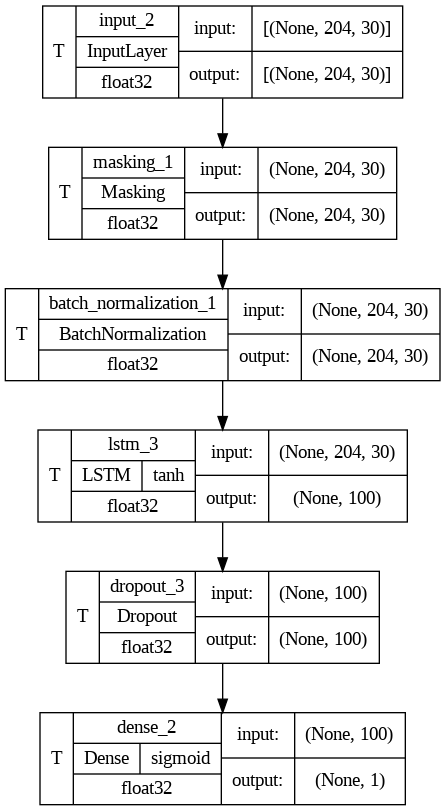

In [ ]:
tf.keras.utils.plot_model(model1,
                          #to_file = f'{path}/Data/Structure.png',
                          dpi = 96,
                          show_shapes = True,
                          show_dtype = True,
                          show_layer_names = True,
                          show_layer_activations = True,
                          expand_nested=True,
                          show_trainable=True)

## Fit the model

In [ ]:

%%time
history = model1.fit(X_train,
                     y_train,
                     batch_size = 64,
                     epochs = 100,
                     shuffle = False,
                     verbose = True,
                     validation_split = 0.2)


Epoch 1/100
150/150 [==============================] - 9s 29ms/step - loss: 0.6638 - auc_1: 0.6529 - val_loss: 0.6314 - val_auc_1: 0.7366
Epoch 2/100
150/150 [==============================] - 2s 16ms/step - loss: 0.6352 - auc_1: 0.6913 - val_loss: 0.6158 - val_auc_1: 0.7370
Epoch 3/100
150/150 [==============================] - 2s 16ms/step - loss: 0.6187 - auc_1: 0.7122 - val_loss: 0.5947 - val_auc_1: 0.7535
Epoch 4/100
150/150 [==============================] - 2s 15ms/step - loss: 0.5972 - auc_1: 0.7419 - val_loss: 0.5948 - val_auc_1: 0.7399
Epoch 5/100
150/150 [==============================] - 3s 21ms/step - loss: 0.5507 - auc_1: 0.7931 - val_loss: 0.5926 - val_auc_1: 0.7387
Epoch 6/100
150/150 [==============================] - 2s 16ms/step - loss: 0.5714 - auc_1: 0.7770 - val_loss: 0.6075 - val_auc_1: 0.7412
Epoch 7/100
150/150 [==============================] - 2s 15ms/step - loss: 0.5618 - auc_1: 0.7826 - val_loss: 0.5869 - val_auc_1: 0.7467
Epoch 8/100
150/150 [=============

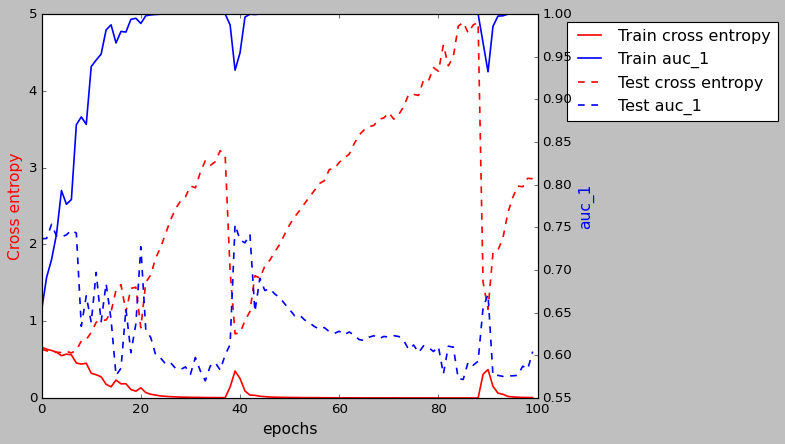

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
l1 = ax.plot(history.history['loss'],
             color="red",
             label = 'Train cross entropy',
             linewidth = 1.5,
             linestyle = '-'
             )
l2 = ax.plot(history.history['val_loss'],
             color="red",
             label = 'Test cross entropy',
             linewidth = 1.5,
             linestyle = '--'
             )

# set x-axis label
ax.set_xlabel("epochs", fontsize = 14)
# set y-axis label
ax.set_ylabel("Cross entropy",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l3 = ax2.plot(history.history['auc_1'],
              color="blue",
              label = 'Train auc_1',
              linewidth = 1.5,
              linestyle = '-'
             )

l4 = ax2.plot(history.history['val_auc_1'],
              color="blue",
              label = 'Test auc_1',
              linewidth = 1.5,
              linestyle = '--'
             )

ax2.set_ylabel("auc_1",color="blue",fontsize=14)

lns = l1+l3+l2+l4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, bbox_to_anchor = (1.5, 1))

plt.show()


## Export model

In [ ]:
model1.save(f'{path}/Saved results/model1.keras')

## Model evaluation

In [ ]:
model1 = keras.models.load_model(f'{path}/Saved results/model1.keras')

In [ ]:
y_pred = model1.predict(X_test)

370/370 [==============================] - 3s 5ms/step


In [ ]:
df_oot = pd.DataFrame(y_pred)

df_oot.index = ind_test
df_oot.columns = ['PRED']

df_oot['TEST'] = y_test

In [ ]:
time_in_day = df_oot.iloc[0:51, :].index.time

In [ ]:
df_gini = pd.DataFrame(index = time_in_day)
from sklearn.metrics import roc_auc_score

for idt, time in enumerate(time_in_day):
    df_calc = df_oot[df_oot.index.time == time]
    df_gini.loc[time, 'GINI'] = 2*roc_auc_score(df_calc['TEST'], df_calc['PRED']) - 1

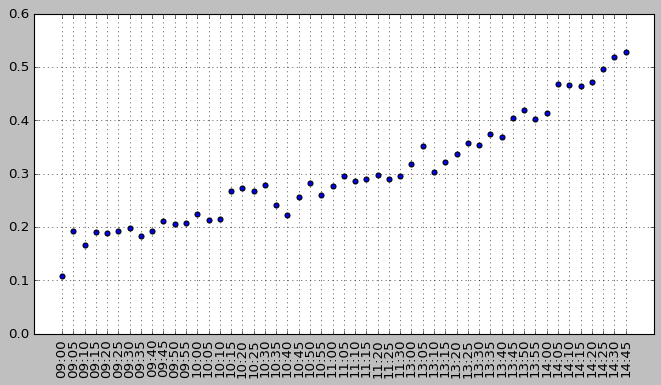

In [ ]:
ind = [str(time)[:-3] for time in time_in_day]


plt.figure(figsize = (10, 5))
plt.scatter(ind, df_gini['GINI'])

plt.xticks(rotation = 90)
plt.grid()
plt.show()